In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure  prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install yfinance
!pip install MiniSom

--2021-08-06 16:36:16--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-08-06 16:36:16--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-08-06 16:36:17--  https://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl

#Part I: Features Engineering

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# import os
# import time
# import datetime
import numpy as np
import pandas as pd
from pathlib import Path
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
import yfinance as yf
from pandas_datareader.famafrench import get_available_datasets
from pandas import Series, DataFrame

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error,r2_score, median_absolute_error, classification_report, confusion_matrix
# from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
# SOM
from minisom import MiniSom

# Visualization library
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
from matplotlib.patches import Patch
%matplotlib inline

import seaborn as sn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense,LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import talib
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [ ]:


data = yf.download('Gold', start='2000-01-01' , end='2019-12-31', progress=False)
print(data.head(5))
title = data.columns
print(title)

               Open     High      Low    Close  Adj Close   Volume
Date                                                              
2000-01-03  17.5625  18.1875  17.4375  17.6875  13.662113  1509900
2000-01-04  17.3125  17.6875  17.1250  17.4375  13.469009  1787100
2000-01-05  17.5625  17.8750  17.4375  17.7500  13.710393  1285100
2000-01-06  17.7500  17.8125  17.5000  17.7500  13.710393  1139300
2000-01-07  17.8125  17.8750  17.2500  17.3125  13.372457  1199900
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


(5030, 30)
(5030, 1)
X: (5021, 30)
X 10:                Open     High      Low  ...      TR            AD        OBV
Date                                   ...                                 
2000-01-14  17.1250  17.1875  16.9375  ...  0.2500 -3.031470e+06 -1971900.0
2000-01-18  17.2500  17.6875  17.1250  ...  0.7500 -1.730414e+06   370000.0
2000-01-19  17.4375  17.5000  17.2500  ...  0.3125 -2.511964e+06 -1193100.0
2000-01-20  17.1875  17.1875  17.0000  ...  0.3125 -3.010197e+06 -2687800.0
2000-01-21  17.0625  17.2500  17.0000  ...  0.2500 -3.010197e+06 -1300700.0
2000-01-24  16.9375  17.0000  16.4375  ...  0.6875 -4.447142e+06 -3887200.0
2000-01-25  16.8125  16.8125  16.3750  ...  0.4375 -4.979942e+06 -5130400.0
2000-01-26  16.5000  16.6250  16.1875  ...  0.4375 -5.888370e+06 -6402200.0
2000-01-27  16.3125  17.0000  16.1875  ...  0.8125 -3.622032e+06 -3723800.0
2000-01-28  16.8750  17.0625  16.2500  ...  0.8125 -4.751647e+06 -5058800.0

[10 rows x 30 columns]


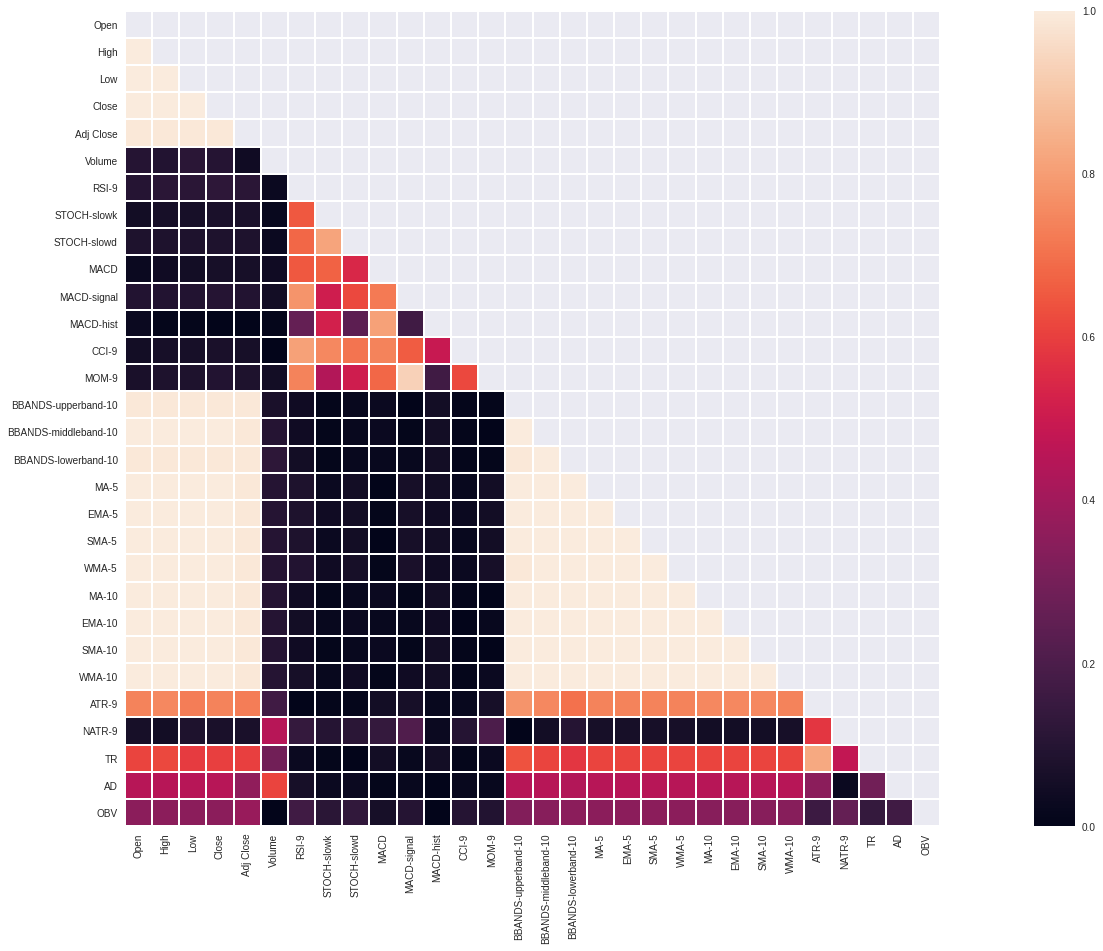

                      Close
Open                   1.00
High                   1.00
Low                    1.00
Close                  1.00
Adj Close              0.99
BBANDS-upperband-10    0.99
BBANDS-middleband-10   1.00
BBANDS-lowerband-10    0.99
MA-5                   1.00
EMA-5                  1.00
SMA-5                  1.00
WMA-5                  1.00
MA-10                  1.00
EMA-10                 1.00
SMA-10                 1.00
WMA-10                 1.00
ATR-9                  0.74
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'BBANDS-upperband-10',
       'BBANDS-middleband-10', 'BBANDS-lowerband-10', 'MA-5', 'EMA-5', 'SMA-5',
       'WMA-5', 'MA-10', 'EMA-10', 'SMA-10', 'WMA-10', 'ATR-9'],
      dtype='object')


In [ ]:
#Momentum Indicators
data["RSI-9"] = talib.RSI(data["Close"], timeperiod=9)
#Stochastic K
data["STOCH-slowk"],data["STOCH-slowd"] = talib.STOCH(data["High"],data["Low"],data["Close"], fastk_period=2,
                            slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data["MACD"], data["MACD-signal"], data["MACD-hist"] = talib.MACD(data['Close'],fastperiod=2,
                                                                  slowperiod=3, signalperiod=8)
# data = data.drop('macd_hist',axis=1)
data['CCI-9'] = talib.CCI(data["High"],data["Low"],data["Close"], timeperiod=9)
data['MOM-9'] = talib.MOM(data["Close"], timeperiod=9)
#Overlap Studies
#Bollinger Bands
data["BBANDS-upperband-10"],data["BBANDS-middleband-10"],data["BBANDS-lowerband-10"] = talib.BBANDS(data["Close"], timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
data["MA-5"] = talib.MA(data["Close"], timeperiod=5)
data['EMA-5'] = talib.EMA(data["Close"], timeperiod=5)
data['SMA-5'] = talib.SMA(data["Close"], timeperiod=5)
data['WMA-5'] = talib.WMA(data["Close"], timeperiod=5)
data["MA-10"] = talib.MA(data["Close"], timeperiod=10)
data['EMA-10'] = talib.EMA(data["Close"], timeperiod=10)
data['SMA-10'] = talib.SMA(data["Close"], timeperiod=10)
data['WMA-10'] = talib.WMA(data["Close"], timeperiod=10)
#Volatility Indicators
data['ATR-9'] = talib.ATR(data["High"],data["Low"],data["Close"], timeperiod=9)
data['NATR-9'] = talib.NATR(data["High"],data["Low"],data["Close"], timeperiod=9)
data['TR'] = talib.TRANGE(data["High"],data["Low"],data["Close"])
#Volume Indicators
#Acc/Dist
data['AD'] = talib.AD(data["High"],data["Low"],data["Close"], data["Volume"])
#On Balance Volume
data['OBV'] = talib.OBV(data["Close"], data["Volume"])


X_feature = data
# .iloc[:,6:]
# print(X_feature.columns)
print(X_feature.shape)
y = data[['Close']]
print(y.shape)

X_feature[['Close']] = y
X = X_feature.dropna()
print("X:",X.shape)
print("X 10:",X.head(10))

#
feature_names = X.columns
feat_num = len(feature_names)

plt.figure(figsize=(feat_num,feat_num/2))
feature_df = X
corrMatrix = feature_df.corr().round(2)
corrMatrix = abs(corrMatrix)
# print(corrMatrix)
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
sn.heatmap(corrMatrix, mask=mask,linewidth=1, square=True)

# plt.tight_layout()
# plt.figure(figsize=(10,1))
plt.show()

df_feature = corrMatrix[['Close']]
df_feature = df_feature[df_feature.Close >0.6]
print(df_feature)
print(df_feature.index)



#Part II: Pipeline Formation (considerations)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 60)                14880     
_________________________________________________________________
Output (Dense)               (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
59/59 [==============================] - 4s 41ms/step - loss: 0.1069 - val_loss: 0.0085

Epoch 00001: val_loss improved from inf to 0.00848, saving model to results/lstm_time_series/model.h5
Epoch 2/100
59/59 [==============================] - 2s 38ms/step - loss: 0.0324 - val_loss: 0.0116

Epoch 00002: val_loss did not improve from 0.00848
Epoch 3/100
59/59 [==============================] - 2s 37ms/step - loss: 0.0183 - val_loss: 0.0049

Epoch 00003: val_loss improved from 0.00848 to 0.00

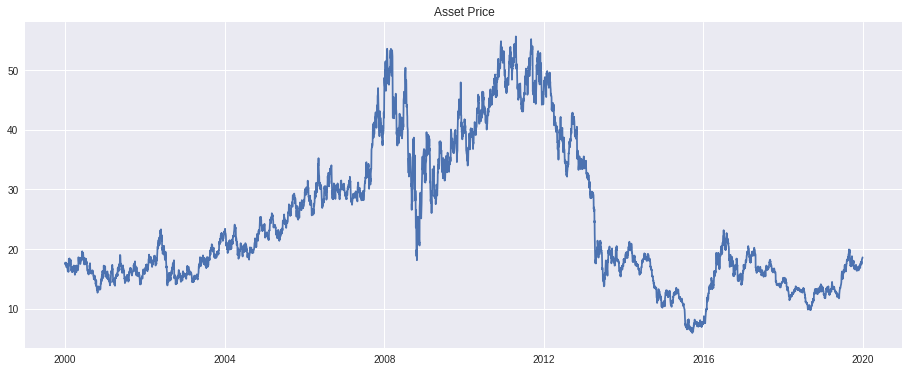

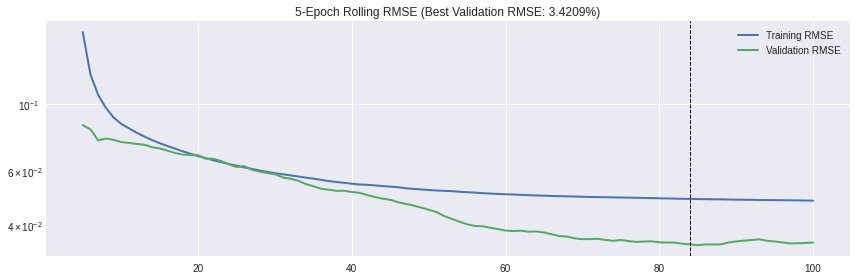

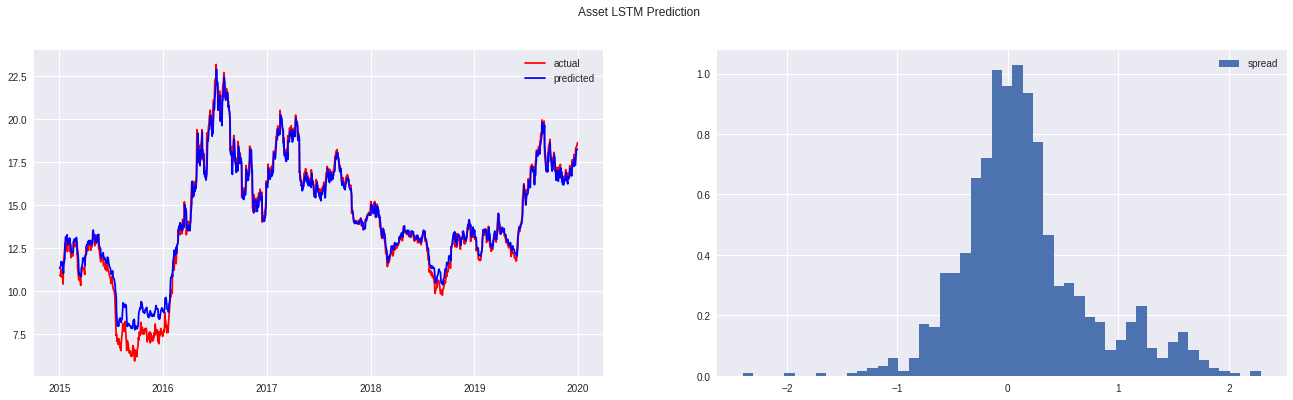

In [ ]:
feature_names = df_feature.index.values

X = X[feature_names]

plt.figure(figsize=(14,6))
plt.title('Asset Price')
plt.plot(y);

# scaler = MinMaxScaler()
scaler = RobustScaler()
data_scaled = pd.Series(scaler.fit_transform(y).squeeze(), index=y.index)

def generate_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 60
X, y = generate_data(data_scaled, window_size=window_size)


# split the data before and after 2015
X_train = X[:'2015-01-01'].values.reshape(-1, window_size, 1)
y_train = y[:'2015-01-01']

# keep the last five year for testing
X_test = X['2015-01-01':].values.reshape(-1, window_size, 1)
y_test = y['2015-01-01':]

batch, timesteps, features = X_train.shape

# complie model five
model = Sequential()
model.add(LSTM(units=X.shape[1], input_shape=(timesteps, features), activation = 'relu', name='LSTM'))
model.add(Dense(units=1, name='Output'))
# model.compile(optimizer='adam', loss='mse')
print(model.summary())
# specify optimizer separately (preferred method)
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='mean_squared_error')

model_path = (results_path / 'model.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=20,
                              restore_best_weights=True)

lstm_training = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    epochs=100,
                    verbose=1,
                    callbacks=[early_stopping, checkpointer],
                    validation_data=(X_test, y_test), shuffle=False)

fig, ax = plt.subplots(figsize=(12, 4))

# derive rmse for the training/validation loss
loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1

# get the best rmse and iteration of the same
best_rmse = loss_history.val_loss.min()
best_epoch = loss_history.val_loss.idxmin()

# plot rolling 5-iteration rmse
loss_history.columns=['Training RMSE', 'Validation RMSE']
title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

# location of best iteration
ax.axvline(best_epoch, ls='--', lw=1, c='k')

# save figure
fig.tight_layout()
fig.savefig(results_path / 'lstm_error', dpi=300);

train_rmse_scaled = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(X_test, y_test, verbose=0))

print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

# predictions
y_pred = model.predict(X_test)
y_pred = pd.Series(scaler.inverse_transform(y_pred).squeeze(), index=y_test.index)

# rescale y
y_test_rescaled = pd.Series(scaler.inverse_transform(y_test.to_frame()).squeeze(), index = y_test.index)
print(f'R-square: {r2_score(y_test_rescaled, y_pred):0.4}')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(y_test_rescaled, color='red', label='actual')
ax[0].plot(y_pred, color='blue', label='predicted')
ax[1].hist(y_pred - y_test_rescaled, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('Asset LSTM Prediction');


